I'm having a look at how to optimise mashed shuffling (for magic reasons!)

In [1]:
%matplotlib inline

import os

import random
import pickle

import json

import numpy as np
from scipy.stats import multivariate_normal as multinomial
from scipy.stats import rv_discrete
from scipy.stats import norm

import pandas as pd

from matplotlib import pyplot
import seaborn

from mtgsdk import Card

A function to return card names from the mtgsdk.

In [2]:
def get_card(card_name):
    print(f'Retrieving: {card_name.title()}.')
    card = Card.where(name=card_name).all()[0]
    print(f'{card_name.title()} retrieved!\n')
    
    return card

A rifle shuffle function.
TODO : make this work for an arbitrary left/right hand drop

In [3]:
def rifle_shuffle(deck_list):
    
    pile = []
    
    a = [a for a in range(28,33)]
    split = random.choices(a)[0]
    
    d = [a for a in range(1,2)]
    
    half1 = deck_list[:split]
    half2 = deck_list[split:]
    
    while (half1 and half2):
        half1_drop_number = random.choices(d)[0]
        half2_drop_number = random.choices(d)[0]
        pile = pile + half1[-half1_drop_number:] + half2[-half2_drop_number:]
        half1 = half1[:-half1_drop_number]
        half2 = half2[:-half2_drop_number]
        
    if half1:
        pile = half1 + pile
        
    if half2:
        pile = half2 + pile
    
    return pile

Overhand shuffling algorithm.

In [4]:
def overhand_shuffle(deck_list):
    a = [x for x in range(100)]
    
    pdf = multinomial.pdf(a, mean=7, cov=6)
    norm_pdf = [(val/sum(pdf)) for val in pdf]
        
    right_hand = deck_list[:]
    left_hand = []
    while len(right_hand) > 7:
        overhand_dist = rv_discrete(a=1, b=len(right_hand), values=(a,norm_pdf))
        drop = overhand_dist.rvs(size=1)[0]
        left_hand = right_hand[:drop] + left_hand
        right_hand = right_hand[drop:]
    left_hand = right_hand + left_hand
    right_hand = []
    
    return left_hand

Function to combine different shuffle types, and examine the hand retrieved from this process.

In [5]:
def create_hand(deck):
    
    hand = [item for item in deck[:7]]

    df = make_dataframe(hand)
    
    hand_types = list(df['type'])
        
    hand_cards = list(df['name'])
                
    hand_qualities = []
    
    for item in list(df['quality']):
        if isinstance(item, str):
            hand_qualities.append([item])
        else:
            hand_qualities.append(item)
            
    hand_qualities = set(flatten_list(hand_qualities))
    
    return hand, hand_types, hand_cards, hand_qualities

In [6]:
def make_dataframe(deck, parameters=['name', 'mana_cost', 
                                     'cmc', 'quality', 'type']):
    
    keys = []
    values = []

    data = []

    for card in deck:
        values = []

        for item in parameters:
            values.append(getattr(card, item))

        data.append(values)

    df = pd.DataFrame(data, columns=parameters)
    
    return df

In [7]:
def shuffle_iterator(deck, search_criteria, iterations=1000,
            overhand_interval=2):
    
    stats = []

    for i in range(iterations):
        deck = list(random.sample(deck_list, len(deck_list)))
        shuffles = 0
        overhand_shuffles = False
        
        hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
        while not (search_criteria['quality'].issubset(hand_qualities)
                   and ((hand_types.count('Basic Land — Swamp') == 2) or
                        ((hand_cards.count('Urborg, Tomb of Yawgmoth') == 1) and
                         (hand_types.count('Land') == 2)))):
            
            deck = rifle_shuffle(deck)
            
            hand, hand_types, hand_cards, hand_qualities = create_hand(deck)
        
            shuffles = shuffles + 1
            
            if (shuffles % overhand_interval) == 0:
                overhand_shuffles = True
            else:
                overhand_shuffles = False

        stats.append({'shuffles': shuffles, 'hand': hand})

    return stats

In [8]:
def flatten_list(list_of_lists):
    flat_list = [item for sublist in list_of_lists for item in sublist]
    
    return flat_list

In [9]:
def make_list(item):
    if not isinstance(item, list):
        item = [item]
    
    return item

In [10]:
deck_json = 'deck.json'
deck_pickle = 'deck.pkl'

if os.path.isfile(deck_pickle):
    with open(deck_pickle, 'rb') as f:
        deck_list = pickle.load(f)
else:
    with open(deck_json, 'rb') as f:
        card_list = json.load(f)

    cards = {}

    for i in card_list.keys():
        name = card_list[i]['name']
        quantity = card_list[i]['quantity']
        quality = card_list[i]['quality']
        card = get_card(name)
        card.quality = quality
        cards[name] = [card, quantity]

    deck_list = []

    for key in cards.keys():
        for i in range(0,cards[key][1]):
            deck_list.append(cards[key][0])
    with open('deck.pkl', 'wb') as f:
        pickle.dump(deck_list, f)

In [11]:
deck = list(random.sample(deck_list, len(deck_list)))

search_terms = {'quality': {'targetted discard', 
                            'win condition',
                            'recurring'}}

stats = shuffle_iterator(deck, search_terms)

In [12]:
number_of_shuffles = [stat['shuffles'] for stat in stats]

Modal number of shuffles is: 4
Average number of shuffles is: 31.655


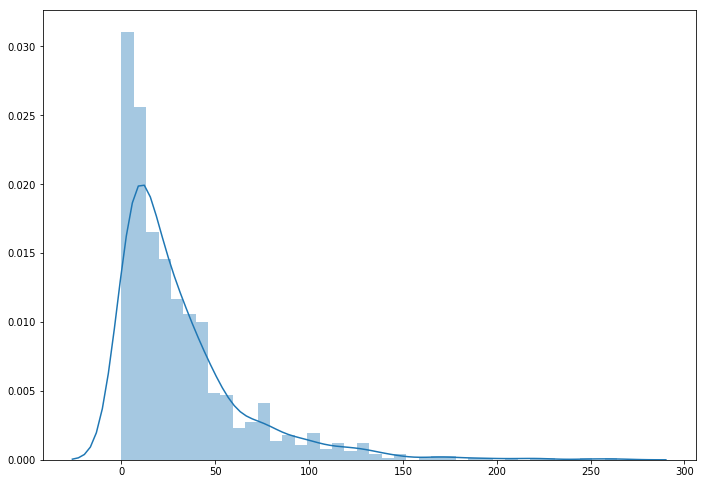

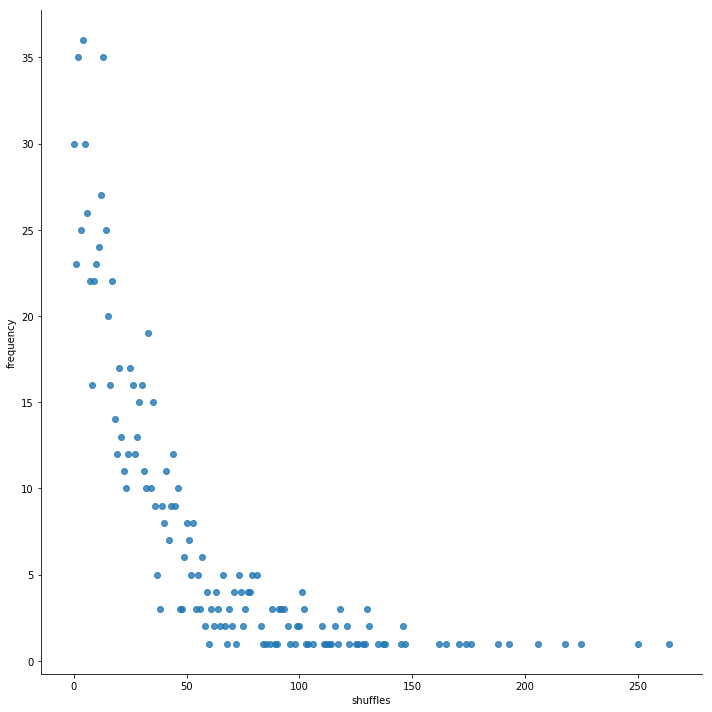

In [13]:
print(f'Modal number of shuffles is: {max(set(number_of_shuffles), key=number_of_shuffles.count)}')
print(f'Average number of shuffles is: {sum(number_of_shuffles)/len(number_of_shuffles)}')

dist = {x:number_of_shuffles.count(x) for x in number_of_shuffles}

scatter_keys = []
scatter_values = []

for key, value in dist.items():
    scatter_keys.append(key)
    scatter_values.append(value)

scatter_data = pd.DataFrame({'shuffles': scatter_keys,
                             'frequency': scatter_values})
    

a4_dims = (11.7, 8.27)
fig, ax = pyplot.subplots(figsize=a4_dims)

seaborn.distplot(number_of_shuffles, ax=ax)
seaborn.lmplot('shuffles', 'frequency', scatter_data, fit_reg=False, size=10)

In [14]:
total = 0
cumulative = []

keys = dist.keys()
keys = sorted(keys)

for key in keys:
    total = total + int(dist[key])
    cumulative.append(total)

In [15]:
for i, item in enumerate(cumulative):
    print(i, 100 * float(item)/float(total))

0 3.0
1 5.3
2 8.8
3 11.3
4 14.9
5 17.9
6 20.5
7 22.7
8 24.3
9 26.5
10 28.8
11 31.2
12 33.9
13 37.4
14 39.9
15 41.9
16 43.5
17 45.7
18 47.1
19 48.3
20 50.0
21 51.3
22 52.4
23 53.4
24 54.6
25 56.3
26 57.9
27 59.1
28 60.4
29 61.9
30 63.5
31 64.6
32 65.6
33 67.5
34 68.5
35 70.0
36 70.9
37 71.4
38 71.7
39 72.6
40 73.4
41 74.5
42 75.2
43 76.1
44 77.3
45 78.2
46 79.2
47 79.5
48 79.8
49 80.4
50 81.2
51 81.9
52 82.4
53 83.2
54 83.5
55 84.0
56 84.3
57 84.9
58 85.1
59 85.5
60 85.6
61 85.9
62 86.1
63 86.5
64 86.8
65 87.0
66 87.5
67 87.7
68 87.8
69 88.1
70 88.3
71 88.7
72 88.8
73 89.3
74 89.7
75 89.9
76 90.2
77 90.6
78 91.0
79 91.5
80 92.0
81 92.2
82 92.3
83 92.4
84 92.5
85 92.8
86 92.9
87 93.0
88 93.3
89 93.6
90 93.9
91 94.1
92 94.2
93 94.3
94 94.5
95 94.7
96 95.1
97 95.4
98 95.5
99 95.6
100 95.7
101 95.9
102 96.0
103 96.1
104 96.2
105 96.3
106 96.5
107 96.6
108 96.9
109 97.1
110 97.2
111 97.3
112 97.4
113 97.5
114 97.6
115 97.9
116 98.1
117 98.2
118 98.3
119 98.4
120 98.5
121 98.7
122 98.8
123 98